In [1]:
import autoreg
import GPy
import numpy as np
from pylab import *
import tables
from IPython.display import HTML
%matplotlib inline

In [2]:
def gen_frames(data, data_mean, data_std, skel, imgpath):
    import os
    import GPy
    a = np.zeros((62,))
    fig = figure(figsize=(8,10))
    ax = fig.add_subplot(111, projection='3d',aspect='equal')
    ax.view_init(elev=20., azim=65)
    fig.tight_layout()
    a[3:] = (data[0])*data_out_std+data_out_mean
    p = GPy.plotting.matplot_dep.visualize.skeleton_show(a, skel ,axes=ax)
    for i in xrange(data.shape[0]):
        a[3:] = (data[i])*data_out_std+data_out_mean
        p.modify(a)
        fig.savefig(os.path.join(imgpath,'%05d'%i+'.png'))

In [3]:
from GPy.util.datasets import *

def cmu_mocap_xyz(subject, train_motions, test_motions=[], sample_every=4, data_set='cmu_mocap'):
    """Load a given subject's training and test motions from the CMU motion capture data."""
    # Load in subject skeleton.
    subject_dir = os.path.join(data_path, data_set)

    # Make sure the data is downloaded.
    all_motions = train_motions + test_motions
    resource = cmu_urls_files(([subject], [all_motions]))
    data_resources[data_set] = data_resources['cmu_mocap_full'].copy()
    data_resources[data_set]['files'] = resource['files']
    data_resources[data_set]['urls'] = resource['urls']
    if resource['urls']:
        download_data(data_set)

    skel = GPy.util.mocap.acclaim_skeleton(os.path.join(subject_dir, subject + '.asf'))
    
    
    for i in range(len(skel.vertices)):
        print i, skel.vertices[i].name     

    
    # 0 root
    # 1 lhipjoint
    # 2 lfemur
    # 3 ltibia
    # 4 lfoot
    # 5 ltoes
    # 6 rhipjoint
    # 7 rfemur
    # 8 rtibia
    # 9 rfoot
    # 10 rtoes
    # 11 lowerback
    # 12 upperback
    # 13 thorax
    # 14 lowerneck
    # 15 upperneck
    # 16 head
    # 17 lclavicle
    # 18 lhumerus
    # 19 lradius
    # 20 lwrist
    # 21 lhand
    # 22 lfingers
    # 23 lthumb
    # 24 rclavicle
    # 25 rhumerus
    # 26 rradius
    # 27 rwrist
    # 28 rhand
    # 29 rfingers
    # 30 rthumb

    
    
    
    
    # Set up labels for each sequence
    exlbls = np.eye(len(train_motions))

    # Load sequences
    tot_length = 0
    temp_Y = []
    temp_Yxyz = []
    temp_lbls = []
    #u_inds = [15,16,17]
    #root_inds = [0,1,2]
    u_inds=[17]
    root_inds = [2]
    
    for i in range(len(train_motions)):
        temp_chan = skel.load_channels(os.path.join(subject_dir, subject + '_' + train_motions[i] + '.amc'))
        #temp_xyz_chan = skel.to_xyz(temp_chan.flatten()) ## A
        # Apparently the above is equiv. to giving temp_chan[0,:]. It's returning a 31 x 3 matrix.
        # I need to do this for every temp_chan[j,:], and serialize the result. The toe should be the
        # very last dimension (I think).
        #temp_xyz_chan = np.zeros((temp_chan.shape[0],93))
        #A -------
        temp_xyz_chan = np.zeros((temp_chan.shape[0],len(u_inds)))                        
        for j in range(temp_xyz_chan.shape[0]):                                 
            foo = skel.to_xyz(temp_chan[j,:]).flatten()
            temp_xyz_chan[j,:] = foo[u_inds] - foo[root_inds]
        #----A
        temp_Y.append(temp_chan[::sample_every, :])
        temp_Yxyz.append(temp_xyz_chan[::sample_every, :]) ## A
        temp_lbls.append(np.tile(exlbls[i, :], (temp_Y[i].shape[0], 1)))
        tot_length += temp_Y[i].shape[0]

    Y = np.zeros((tot_length, temp_Y[0].shape[1]))
    Yxyz = np.zeros((tot_length, temp_Yxyz[0].shape[1])) #A
    lbls = np.zeros((tot_length, temp_lbls[0].shape[1]))

    #pb.plot(temp_Yxyz[-1][:,15:18]-temp_Yxyz[-1][:,0:3],'x-')

    end_ind = 0
    for i in range(len(temp_Y)):
        start_ind = end_ind
        end_ind += temp_Y[i].shape[0]
        Y[start_ind:end_ind, :] = temp_Y[i]
        Yxyz[start_ind:end_ind, :] = temp_Yxyz[i] #A
        lbls[start_ind:end_ind, :] = temp_lbls[i]
    if len(test_motions) > 0:
        temp_Ytest = []
        temp_lblstest = []
        temp_Yxyz_test = []

        testexlbls = np.eye(len(test_motions))
        tot_test_length = 0
        for i in range(len(test_motions)):
            temp_chan = skel.load_channels(os.path.join(subject_dir, subject + '_' + test_motions[i] + '.amc'))
            #A -------
            temp_xyz_chan = np.zeros((temp_chan.shape[0],len(u_inds)))                        
            for j in range(temp_xyz_chan.shape[0]):                                 
                foo = skel.to_xyz(temp_chan[j,:]).flatten()
                temp_xyz_chan[j,:] = foo[u_inds] - foo[root_inds]
            #----A
            temp_Ytest.append(temp_chan[::sample_every, :])
            temp_Yxyz_test.append(temp_xyz_chan[::sample_every, :]) ## A
            temp_lblstest.append(np.tile(testexlbls[i, :], (temp_Ytest[i].shape[0], 1)))
            tot_test_length += temp_Ytest[i].shape[0]

        # Load test data
        Ytest = np.zeros((tot_test_length, temp_Ytest[0].shape[1]))
        Yxyz_test = np.zeros((tot_test_length, temp_Yxyz_test[0].shape[1])) #A
        lblstest = np.zeros((tot_test_length, temp_lblstest[0].shape[1]))

        end_ind = 0
        for i in range(len(temp_Ytest)):
            start_ind = end_ind
            end_ind += temp_Ytest[i].shape[0]
            Ytest[start_ind:end_ind, :] = temp_Ytest[i]
            Yxyz_test[start_ind:end_ind, :] = temp_Yxyz_test[i] #A
            lblstest[start_ind:end_ind, :] = temp_lblstest[i]
    else:
        Ytest = None
        lblstest = None

    info = 'Subject: ' + subject + '. Training motions: '
    for motion in train_motions:
        info += motion + ', '
    info = info[:-2]
    if len(test_motions) > 0:
        info += '. Test motions: '
        for motion in test_motions:
            info += motion + ', '
        info = info[:-2] + '.'
    else:
        info += '.'
    if sample_every != 1:
        info += ' Data is sub-sampled to every ' + str(sample_every) + ' frames.'
    return data_details_return({'Y': Y, 'lbls' : lbls, 'Ytest': Ytest, 'lblstest' : lblstest, 'info': info, 'skel': skel,'Yxyz':Yxyz,'Yxyz_test':Yxyz_test,'u_inds':u_inds,'root_inds':root_inds,'Yxyz_list':temp_Yxyz,'Yxyz_list_test':temp_Yxyz_test}, data_set)




In [4]:
def load_data():
    from GPy.util.datasets import cmu_mocap
    train_motions = ['01', '02', '03', '04', # walking
                '17', '18', '19', '20'] # running
    test_motions = ['05','21']
    data = cmu_mocap('35', train_motions, test_motions, sample_every=4, data_set='cmu_mocap')
    return data

def load_data_xyz():
    train_motions = ['01', '02', '03', '04', # walking
                '17', '18', '19', '20'] # running
    test_motions = ['05','21']
    data = cmu_mocap_xyz('35', train_motions, test_motions, sample_every=4, data_set='cmu_mocap')
    return data

In [5]:
#data = load_data()
data = load_data_xyz()

0 root
1 lhipjoint
2 lfemur
3 ltibia
4 lfoot
5 ltoes
6 rhipjoint
7 rfemur
8 rtibia
9 rfoot
10 rtoes
11 lowerback
12 upperback
13 thorax
14 lowerneck
15 upperneck
16 head
17 lclavicle
18 lhumerus
19 lradius
20 lwrist
21 lhand
22 lfingers
23 lthumb
24 rclavicle
25 rhumerus
26 rradius
27 rwrist
28 rhand
29 rfingers
30 rthumb


In [6]:

y = data['Y']
u = data['Yxyz_list']
u_flat = np.vstack(u)

lbls = data['lbls']
data_out_train = y

#---- REMOVE
datatmp = load_data()
if np.sum(np.abs(y - datatmp['Y'])) != 0:
    print np.sum(y - datatmp['Y'])
#----

data_out_train = data_out_train[:,3:]
data_out_mean  = data_out_train.mean(axis=0)
data_out_std   = data_out_train.std(axis=0)
data_out_train = (data_out_train-data_out_mean)/data_out_std
#data_out_train_list = [data_out_train[np.where(lbls[:,i]==1)[0]][1:] for i in range(lbls.shape[1])]
data_out_train_list = [data_out_train[np.where(lbls[:,i]==1)[0]] for i in range(lbls.shape[1])]


# Create controls
#data_in_train_list = [y[np.where(lbls[:,i]==1)[0]][:,2][1:] - y[np.where(lbls[:,i]==1)[0]][:,2][:-1] for i in range(lbls.shape[1])]
#from scipy.ndimage.filters import gaussian_filter1d
#data_in_train_list = [np.ones(d.shape+(1,))*d.mean() for d in data_in_train_list]

##data_in_train_list = [gaussian_filter1d(d,8.)[:,None] for d in data_in_train_list]
##data_in_train_list = [np.vstack([d[:10],d]) for d in data_in_train_list]


data_in_train_list = u
u_flat_mean = u_flat.mean(axis=0)
u_flat_std = u_flat.std(axis=0)
data_in_train = (u_flat-u_flat_mean)/u_flat_std
    
#data_in_train_list = u


(90, 1)
(90, 59)
90
102
107
109
42
44
40
41


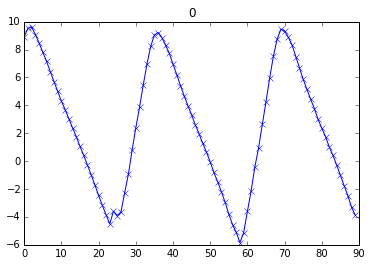

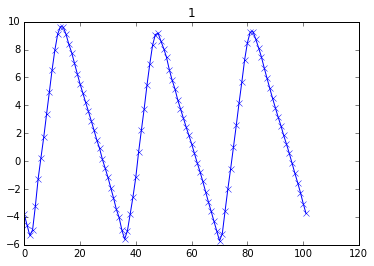

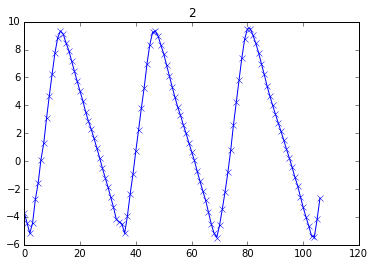

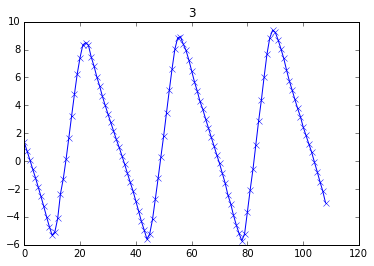

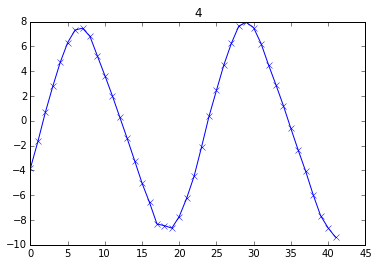

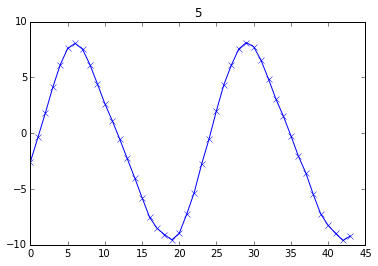

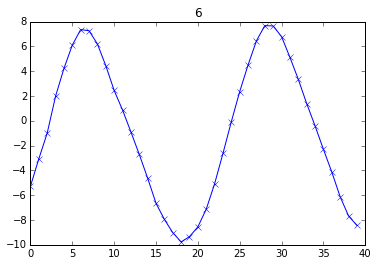

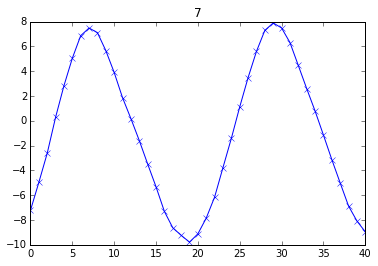

In [7]:
print data_in_train_list[0].shape
print data_out_train_list[0].shape

for i in range(len(data_in_train_list)):
    plt.figure()
    plt.plot(data_in_train_list[i], 'x-')
    plt.title(i)
    print data_in_train_list[i].shape[0]

In [8]:
print y.shape
print data_out_train.shape
print u_flat.shape
print data_in_train.shape



(575, 62)
(575, 59)
(575, 1)
(575, 1)


In [9]:
ytest = data['Ytest']
lblstest = data['lblstest']
u = data['Yxyz_list_test']
data_out_test = ytest

data_out_test= data_out_test[:,3:]
data_out_test = (data_out_test-data_out_mean)/data_out_std

#data_out_test_list = [data_out_test[np.where(lblstest[:,i]==1)[0]][1:] for i in range(lblstest.shape[1])]
data_out_test_list = [data_out_test[np.where(lblstest[:,i]==1)[0]] for i in range(lblstest.shape[1])]

# Create controls
#data_in_test_list = [ytest[np.where(lblstest[:,i]==1)[0]][:,2][1:] - ytest[np.where(lblstest[:,i]==1)[0]][:,2][:-1] for i in range(lblstest.shape[1])]
#data_in_test_list = [np.ones(d.shape+(1,))*d.mean() for d in data_in_test_list]

#data_in_test_list = u

data_in_test_list = u
data_in_test = (u_flat-u_flat_mean)/u_flat_std

In [10]:
len(data_in_test_list)

2

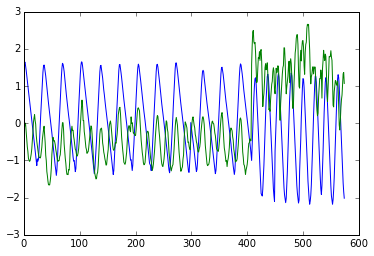

In [11]:
_=plot(data_in_train)
_=plot(data_out_train[:,0])

In [58]:
init_from_saved = False

# Init from saved model
if init_from_saved:
    Q = 100
    
    win_in = 10
    win_out = 10
    
    # create the model
    m = autoreg.DeepAutoreg([0, win_out], data_out_train_list, U=data_in_train_list, U_win=win_in, X_variance=0.05,
                        num_inducing=Q, back_cstr=True, MLP_dims=[500,200], nDims=[data_out_train.shape[1],1],
                         kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=False),
                         GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=False)])

#f = tables.openFile('./first_10.h5','r')
#ps = f.root.param_array[:]
#m.param_array[:] = ps
#f.close()
#m._trigger_params_changed()

In [20]:
Q = 100
win_in = 20
win_out = 20

use_controls = True
back_cstr = True



# create the model
if use_controls:
    m = autoreg.DeepAutoreg([0, win_out], data_out_train, U=data_in_train, U_win=win_in, X_variance=0.05,
                        num_inducing=Q, back_cstr=back_cstr, MLP_dims=[300,200], nDims=[data_out_train.shape[1],1],
                         kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=True),
                         GPy.kern.RBF(win_out+win_in,ARD=True,inv_l=True, useGPU=True)])
else:
    m = autoreg.DeepAutoreg([0, win_out], data_in_train, U=None, U_win=win_in, X_variance=0.05,
                        num_inducing=Q, back_cstr=back_cstr, MLP_dims=[200,100], nDims=[data_out_train.shape[1],1],
                         kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=False),
                         GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=False)])


KeyboardInterrupt: 

In [27]:
#=============================
# Model with NN-constraint
#=============================
Q = 100
win_in = 20
win_out = 20

use_controls = True
back_cstr = True

m = autoreg.DeepAutoreg([0, win_out], data_out_train_list, U=[d*0.1 for d in data_in_train_list], U_win=win_in, X_variance=0.05,
                    num_inducing=Q, back_cstr=back_cstr, MLP_dims=[200,100], nDims=[data_out_train.shape[1],1],
                     kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=True),
                     GPy.kern.RBF(win_out+win_in,ARD=True,inv_l=True, useGPU=True)])

In [146]:
import tables

with tables.openFile('./walk_run_2.h5','r') as f:
    ps = f.root.param_array[:]
    f.close()
    m.param_array[:] = ps
    m._trigger_params_changed()

In [15]:
if not back_cstr:
    pp = GPy.util.pca.PCA(data_out_train)
    m.layer_1.Xs_flat[0].mean[:] = pp.project(data_out_train, 1)
    perm = np.random.permutation(range(m.layer_1.X.mean.shape[0]))
    m._trigger_params_changed()
    m.layer_1.Z[:] = m.layer_1.X.mean[perm[0:Q],:].values.copy()
    m._trigger_params_changed()






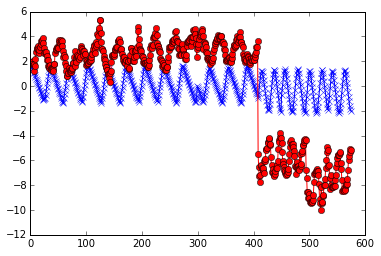

In [16]:
plt.plot(data_in_train, 'x-')
plt.plot(m.layer_1.Xs_flat[0].mean[:], 'ro-')

In [28]:
# initialization
for i in range(m.nLayers):
    if not back_cstr:
        m.layers[i].kern.inv_l[:]  = ((m.layers[i].X.mean.values.max(0)-m.layers[i].X.mean.values.min(0))/np.sqrt(2.))
    else:
        m.layers[i].kern.inv_l[:]  = 1./9.#((m.layers[i].X.mean.values.max(0)-m.layers[i].X.mean.values.min(0))/np.sqrt(2.))
    m.layers[i].likelihood.variance[:] = 0.01*data_out_train.var()
    m.layers[i].kern.variance.fix(warning=False)
    m.layers[i].likelihood.fix(warning=False)

if back_cstr:
    m.layer_1.likelihood.variance[:] = 0.01
    m.layer_1.Z.fix()
else:
    m.layer_1.likelihood.variance[:] = 0.01 * m.layer_1.Xs_flat[0].var()
print m


Name                              : autoreg
Log-likelihood                    : -888981.846948
Number of Parameters              : 35200
Number of Optimization Parameters : 31196
Updates                           : True
Parameters:
  autoreg.                         |       Value        |  Constraint  |  Prior  |  Tied to
  layer_1.inducing inputs          |         (100, 40)  |    fixed     |         |         
  layer_1.rbf.variance             |               1.0  |    fixed     |         |         
  layer_1.rbf.inv_lengthscale      |             (40,)  |     +ve      |         |         
  layer_1.Gaussian_noise.variance  |              0.01  |    fixed     |         |         
  layer_1.init_Xs_0.mean           |           (20, 1)  |              |         |         
  layer_1.init_Xs_0.variance       |           (20, 1)  |     +ve      |         |         
  layer_1.init_Xs_1.mean           |           (20, 1)  |              |         |         
  layer_1.init_Xs_1.variance   

In [29]:
# optimization
m.optimize('bfgs',messages=1,max_iters=100)
m.layer_1.Z.unfix()
for i in range(m.nLayers):
    #m.layers[i].kern.variance.constrain_bounded(0.06, 100, warning=False)
    m.layers[i].kern.variance.constrain_positive(warning=False)
m.optimize('bfgs',messages=1,max_iters=200)
for i in range(m.nLayers):
    m.layers[i].likelihood.constrain_positive(warning=False)
m.optimize('bfgs',messages=1,max_iters=10000)

KeyboardInterrupt: 

In [145]:
# Save the model parameters
m.save('walk_run_2.h5')

In [34]:
m.layer_1.Y.mean.var()

6.6312329981667135

In [35]:
m.layer_1.kern.lengthscale

Index,lengthscale,Constraint,Prior,Tied to
[0],7.68329273157,+ve,,N/A
[1],7.8611135491,+ve,,N/A
[2],8.5647082639,+ve,,N/A
[3],6.48435266492,+ve,,N/A
[4],7.4570698636,+ve,,N/A
[5],6.29864634064,+ve,,N/A
[6],8.17651070338,+ve,,N/A
[7],7.14633628596,+ve,,N/A
[8],7.3776994066,+ve,,N/A
[9],7.06151374458,+ve,,N/A


In [36]:
m.layer_1.X.mean.values.std(0)

array([ 2.09310343,  2.18532603,  2.26136799,  2.3279297 ,  2.35823477,
        2.37389573,  2.39163333,  2.41493356,  2.4253901 ,  2.44012462,
        2.45966883,  2.47845264,  2.49696726,  2.51038767,  2.526227  ,
        2.54100038,  2.56086919,  2.57961285,  2.5897695 ,  2.59246829,
        0.5053552 ,  0.50905189,  0.51167665,  0.51271615,  0.51302051,
        0.51293417,  0.5122048 ,  0.51108828,  0.51025977,  0.50996301,
        0.50970293,  0.5086646 ,  0.50654639,  0.50368615,  0.50054116,
        0.49744697,  0.49462877,  0.49213959,  0.49023948,  0.48934644])

In [ ]:
print m.layer_0.Y.var()

print m

In [ ]:
m.save('walk_run_2.h5')

In [ ]:
# for i in range(m.nLayers):
#     m.layers[i].likelihood.constrain_positive(warning=False)
m.optimize('bfgs',messages=1,max_iters=100000)
print m

In [147]:
#b = data_in_train.copy()
#b[:] = data_in_train.mean()
#pd = m.freerun(U=b, m_match=False)

# Test on training data
ts_inp = data_in_train_list[0].copy()   # data_in_test_list[0]
ts_out = data_out_train_list[0].copy()  # data_out_test_list[0]

pd = m.freerun(init_Xs=[None,m.layer_1.init_Xs_0.copy()],U=ts_inp*0.1, m_match=True)

#pd = pd.mean.values*data_out_std+data_out_mean
#mean_pred = m.layer_0.Y.mean(0)*data_out_std+data_out_mean

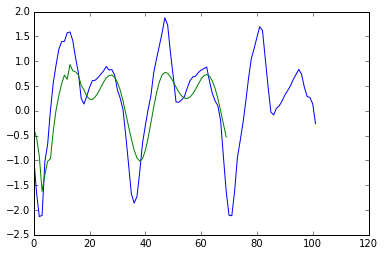

In [148]:
plot(data_out_train_list[1][:,8])
plot(pd.mean[:,8])

In [49]:
m.layer_0.predict(m.layer_0.X.mean)[0]

array([[-0.20025013,  1.03242155,  1.08202054, ...,  1.00407358,
         0.19104485, -0.62864622],
       [-0.35574262,  0.946808  ,  0.94941503, ...,  1.0091159 ,
         0.18041143, -0.62925239],
       [-0.44374375,  0.90263024,  0.66256223, ...,  1.01069108,
         0.21808295, -0.55871537],
       ..., 
       [ 1.50939722, -0.51614563,  0.76525814, ...,  1.01269842,
         1.17091873,  1.26023559],
       [ 1.57152176, -0.76215749,  0.75817165, ...,  0.99508625,
         1.12491829,  1.20965783],
       [ 1.52893813, -0.72838679,  0.79762623, ...,  0.98352326,
         1.21913351,  1.17267549]])

In [53]:
m.layer_0.Y

ObsAr([[ 0.07244304,  0.75399951,  1.27416211, ...,  1.        ,
         0.02860576, -0.69504298],
       [-0.02633985,  0.84832617,  1.13415688, ...,  1.        ,
         0.068178  , -0.65551046],
       [-0.32343214,  0.65903779,  0.55129757, ...,  1.        ,
         0.15138794, -0.56379643],
       ..., 
       [ 1.3283252 , -0.4845209 ,  0.25578027, ...,  1.        ,
         1.53910903,  1.05722438],
       [ 1.36323897, -0.32074978,  0.6832587 , ...,  1.        ,
         1.47393627,  1.06772011],
       [ 1.06903277, -0.11580688,  1.04810706, ...,  1.        ,
         1.43321567,  1.1015333 ]])

In [46]:
pd,data_out_train_list[0][20:]

(array([[-0.26375277, -0.18219682,  0.18444068, ...,  1.00593693,
          0.12552693, -0.41373765],
        [-0.26395142, -0.18217217,  0.1845964 , ...,  1.00593759,
          0.12550427, -0.41385683],
        [-0.26431992, -0.18212641,  0.18488545, ...,  1.00593881,
          0.12546221, -0.41407775],
        ..., 
        [-0.26404648, -0.18233222,  0.1841585 , ...,  1.00594224,
          0.12543457, -0.41384959],
        [-0.26405045, -0.18226257,  0.18441489, ...,  1.00594025,
          0.12547768, -0.41386756],
        [-0.26414711, -0.1821844 ,  0.18469996, ...,  1.00593847,
          0.12548998, -0.41394856]]),
 array([[ 0.07244304,  0.75399951,  1.27416211, ...,  1.        ,
          0.02860576, -0.69504298],
        [-0.02633985,  0.84832617,  1.13415688, ...,  1.        ,
          0.068178  , -0.65551046],
        [-0.32343214,  0.65903779,  0.55129757, ...,  1.        ,
          0.15138794, -0.56379643],
        ..., 
        [-0.2000868 ,  0.98064635,  1.48079019, ...,

In [45]:
pd.shape, data_out_train_list[0].shape

((70, 59), (90, 59))

In [124]:
len(data_in_test_list)

2

In [127]:
ts_inp = data_in_test_list[1]
ts_out = data_out_test_list[1]

pd = m.freerun(U=ts_inp*0.1, m_match=False)

#pd = pd*data_out_std+data_out_mean

In [113]:
data_in_test_list[0].shape

(107, 1)

In [65]:
mean_pred

(87, 59)

In [38]:
print pd[0,:]
print pd[0,:]*data_out_std+data_out_mean
print ts_out[0,:]
mean_pred.shape

[-0.26375277 -0.18219682  0.18444068 -0.00566178 -0.21970811 -0.26193169
  0.07698701 -0.08504683 -0.13497963  0.23134062 -0.05228815 -0.67132009
 -0.19705366  0.27907558 -0.06351447  0.01825189  0.11549222 -0.1187323
  0.07900929 -0.06279296  0.50290286  0.05097909 -0.24627518  0.29240015
  0.04899571 -0.06212851  0.24517031  0.16481581 -1.69557841 -0.37686363
  0.26988015  0.23097896 -0.53385579  0.24638912  0.69451732 -0.15710356
  0.4385375   0.02132559 -0.19365991  0.07228145 -0.0467933  -0.21265332
 -1.6062598  -0.62611447  1.00593693 -1.60630334 -0.62036237 -0.15710356
  0.4385375   0.16494164  0.07410948 -0.14449016  0.00479086  0.07936281
  0.12459751  0.47680249  1.00593693  0.12552693 -0.41373765]
[ -1.51750788e+00  -2.04806545e+00  -1.34638185e+00  -1.13331947e+01
  -1.70720283e+00  -2.22897807e+01   4.08478363e+01  -5.00243969e+00
  -6.62498498e+00  -3.46776261e+00  -1.56301115e+01   1.38683165e+00
   2.53076578e+01   5.03082133e+01  -5.42698781e+00  -6.13339633e+00
   3.9

(59,)

In [ ]:
for i in range(pd.shape[0]):
    pd[i,:] = pd[i,:]*data_out_std+data_out_mean

In [39]:
#for i in range(1):
#    plt.figure()
#    plt.plot(ts_out[:,i])
#    plt.figure()
#    plt.plot(pd[:,i])

print pd[0:50:3,28]
print mean_pred[28]

[-1.69557841 -1.69558306 -1.69523324 -1.69364184 -1.68627577 -1.66418654
 -1.62995566 -1.68368784 -1.71585699 -1.7663893  -1.7733558  -1.69202152
 -1.69553019 -1.69559144 -1.69594445 -1.69302896 -1.68888338]
-2.06725923373


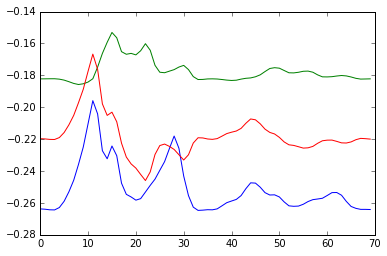

In [40]:
_=plot(pd[:,0])
_=plot(pd[:,1])
_=plot(pd[:,4])
#_=plot(data_out_train[win_out:100,0],'r')
#_=plot(data_out_train[win_out:100,1],'y')

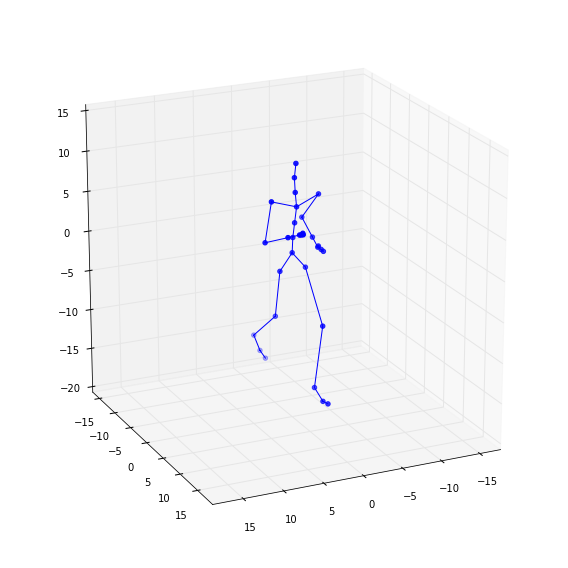

In [135]:
!rm imgs/*.png
gen_frames(pd,data_out_mean, data_out_std, data['skel'],'./imgs')

In [141]:
! avconv -y -r 10 -qscale 2 -i ./imgs/%05d.png pred_walk_run_3.mp4

avconv version 9.18-6:9.18-0ubuntu0.14.04.1, Copyright (c) 2000-2014 the Libav developers
  built on Mar 16 2015 13:19:10 with gcc 4.8 (Ubuntu 4.8.2-19ubuntu1)
Input #0, image2, from './imgs/%05d.png':
  Duration: 00:00:00.84, start: 0.000000, bitrate: N/A
    Stream #0.0: Video: png, bgra, 576x720, 25 fps, 25 tbr, 25 tbn
[libx264 @ 0x1dd2b40] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX
[libx264 @ 0x1dd2b40] profile High, level 2.2
[libx264 @ 0x1dd2b40] 264 - core 142 r2389 956c8d8 - H.264/MPEG-4 AVC codec - Copyleft 2003-2014 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=12 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=

In [142]:
HTML("""
<video width="480" height="480" controls>
  <source src="pred_walk_run_3.mp4" type="video/mp4">
</video>
""")

In [ ]:
m.layer_1.X.mean.values

In [ ]:
m.layer_1.Us_flat[0].variance

In [ ]:
m.layer_1.kern.lengthscale

In [ ]:
m.layer_0.kern.lengthscale

In [ ]:
m.layer_1.X.mean.std(0)

In [ ]:
plot(data_in_train_list[0])
plot(data_in_train_list[6])

In [ ]:
pd = m.freerun(U=np.vstack([data_in_train_list[0],data_in_train_list[5],data_in_train_list[6],data_in_train_list[7]]),m_match=False)